In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [63]:
df = pd.read_excel("Supermarket Transactions.xlsx",sheet_name="Data")
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])

In [64]:
df = df.drop_duplicates()
df = df.dropna()

In [65]:
#spllit data into two datasets from 2011 to 2013 june and 2013 june to max date
train_df = df[df['Purchase Date'] < '2013-06-01']
test_df= df[df['Purchase Date'] >= '2013-06-01']
#to csv
train_df.to_csv("train.csv",index=False)
test_df.to_csv("test.csv",index=False)


PermissionError: [Errno 13] Permission denied: 'train.csv'

In [ ]:
Latest_Date =datetime(2013, 6, 1)

# Create RFM Modelling scores for each customer
RFMScores = train_df.groupby('Customer ID').agg({
    'Purchase Date': lambda x: (Latest_Date - x.max()).days,  # Recency
    'Transaction': lambda x: len(x),  # Frequency
    'Revenue': lambda x: x.sum(),  # Total Revenue
    'Units Sold': lambda x: x.sum(),  # Sum of units sold
    'Children': 'first'  # First value of children (assuming it's the same for each customer)
})

# Rename columns
RFMScores.rename(columns={
    'Purchase Date': 'Recency',
    'Transaction': 'Frequency',
    'Revenue': 'TotalRevenue',
    'Units Sold': 'TotalUnitsSold'
}, inplace=True)

# Calculate additional metrics
RFMScores['Tenure'] = (Latest_Date - train_df.groupby('Customer ID')['Purchase Date'].min()).dt.days  # Tenure in days
RFMScores['Monetary'] = RFMScores['TotalRevenue'] / RFMScores['Frequency']  # Average Order Value (AOV)

# Reset index to make CustomerID a column again
RFMScores.reset_index(inplace=True)

# Display the first few rows of the RFM scores
print(RFMScores.head())

   Customer ID  Recency  Frequency  TotalRevenue  TotalUnitsSold  Children  \
0            3       61          1         29.30               6         1   
1            8        9          1         28.37               4         2   
2           20      505          2         32.13               8         2   
3           26       97          3         34.88               9         0   
4           28      502          1         11.04               4         1   

   Tenure   Monetary  
0      61  29.300000  
1       9  28.370000  
2     520  16.065000  
3     238  11.626667  
4     502  11.040000  


In [ ]:
current_date = datetime(2013, 12, 31)
# current_date = test_df.datetime.max().date() if not test_df.empty else None
print("Current Date:", current_date)
RFMScores_test = test_df.groupby('Customer ID').agg({
    'Purchase Date': lambda x: (current_date - x.max()).days,  # Recency
    'Transaction': lambda x: len(x),  # Frequency
    'Revenue': lambda x: x.sum(),  # Total Revenue
    'Units Sold': lambda x: x.sum(),  # Sum of units sold
    'Children': 'first'  # First value of children (assuming it's the same for each customer)
})

# Rename columns
RFMScores_test.rename(columns={
    'Purchase Date': 'Recency',
    'Transaction': 'Frequency',
    'Revenue': 'TotalRevenue',
    'Units Sold': 'TotalUnitsSold'
}, inplace=True)

# Calculate additional metrics
RFMScores_test['Tenure'] = (current_date - test_df.groupby('Customer ID')['Purchase Date'].min()).dt.days  # Tenure in days
RFMScores_test['Monetary'] = RFMScores_test['TotalRevenue'] / RFMScores_test['Frequency']  # Average Order Value (AOV)

# Reset index to make CustomerID a column again
RFMScores_test.reset_index(inplace=True)

# Display the first few rows of the RFM scores
print(RFMScores_test.head())


Current Date: 2013-12-31 00:00:00
   Customer ID  Recency  Frequency  TotalRevenue  TotalUnitsSold  Children  \
0            8       90          3         36.35              10         2   
1            9       51          2         51.66               9         5   
2           20      131          1         27.14               5         2   
3           24       48          2          8.70               6         0   
4           28      103          2         38.23               7         1   

   Tenure   Monetary  
0     212  12.116667  
1      91  25.830000  
2     131  27.140000  
3     140   4.350000  
4     114  19.115000  


In [ ]:
RFMScores.columns

Index(['Customer ID', 'Recency', 'Frequency', 'TotalRevenue', 'TotalUnitsSold',
       'Children', 'Tenure', 'Monetary'],
      dtype='object')

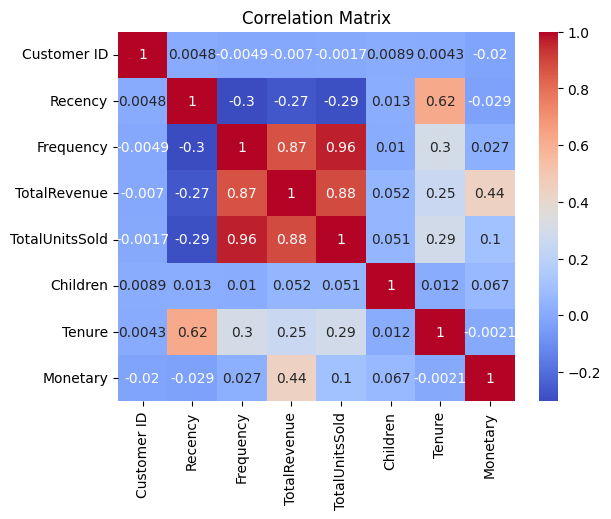

In [ ]:
sns.heatmap(RFMScores.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import shap


In [ ]:
# Check for and drop rows with NaN in features or target
ml_data = RFMScores.drop(columns=['Customer ID'])
ml_data = ml_data.dropna(subset=['TotalRevenue'])  # if using hybrid CLV as target

X_1= ml_data.drop(columns=['TotalRevenue'])  # or the relevant CLV column
y_1= ml_data['TotalRevenue']

# Ensure all features are numeric
X_1 = X_1.select_dtypes(include=[np.number])

# Final split
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

Linear Regression Results
Mean Absolute Error: 4.320542679260804
Mean Squared Error: 40.520689611752054
Root Mean Squared Error: 6.365586352548527
R2 Score: 0.9303259246473274


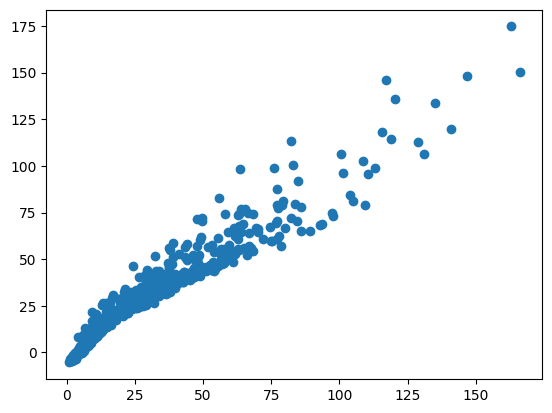

In [ ]:
#linear regression 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  

import numpy as np
# from sklearn.model_selection import train_test_split
linear_model= LinearRegression()

# Replace NaN values with 0
# X_train = np.nan_to_num(X_train, nan=0.0)
# X_test = np.nan_to_num(X_test, nan=0.0)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
# Now you can fit the model without errors
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

print("Linear Regression Results")
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred)


Decision Tree Regression Results
Mean Absolute Error: 0.5527679623085985
Mean Squared Error: 6.808514487632512
Root Mean Squared Error: 2.6093130298284475
R2 Score: 0.9882929694436027


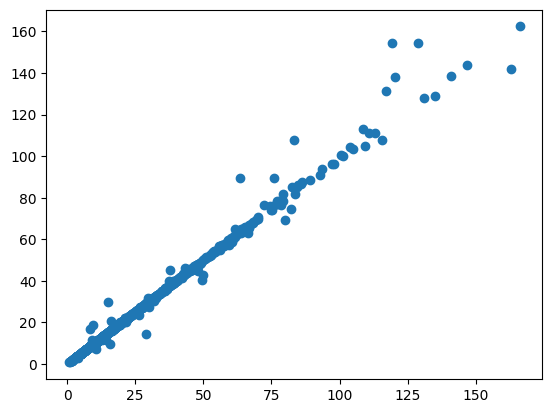

In [ ]:
# decision tree regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)
decision_pred = decision_tree_model.predict(X_test)
print("Decision Tree Regression Results")
print("Mean Absolute Error:", mean_absolute_error(y_test, decision_pred))
print("Mean Squared Error:", mean_squared_error(y_test, decision_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, decision_pred)))
print("R2 Score:", r2_score(y_test, decision_pred))
plt.scatter(y_test, decision_pred)

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators=200)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print("XGBoost RMSE:", mean_squared_error(y_test, xgb_preds))
print("XGBoost R²:", r2_score(y_test, xgb_preds))


XGBoost RMSE: 3.462988851598823
XGBoost R²: 0.9940454975346278


In [ ]:
lgb_model = lgb.LGBMRegressor(n_estimators=200)
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)
print("LightGBM RMSE:", mean_squared_error(y_test, lgb_preds))
print("LightGBM R²:", r2_score(y_test, lgb_preds))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 829
[LightGBM] [Info] Number of data points in the train set: 3393, number of used features: 6
[LightGBM] [Info] Start training from score 26.817253
LightGBM RMSE: 6.907075645608492
LightGBM R²: 0.9881234965739782


In [ ]:
cat_model = CatBoostRegressor(verbose=0)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)
print("CatBoost RMSE:", mean_squared_error(y_test, cat_preds))
print("CatBoost R²:", r2_score(y_test, cat_preds))

CatBoost RMSE: 0.9050969699688695
CatBoost R²: 0.9984437136906772


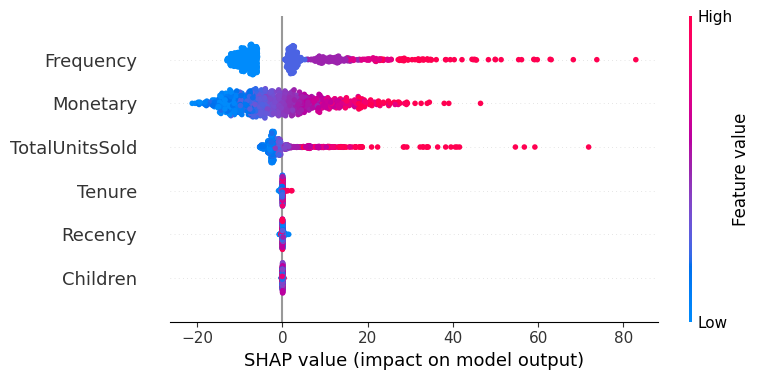

In [ ]:
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [ ]:
ml_data_test = RFMScores_test.drop(columns=['Customer ID'])
ml_data_test= ml_data_test.dropna(subset=['TotalRevenue'])  # if using hybrid CLV as target

X = ml_data_test.drop(columns=['TotalRevenue'])  # or the relevant CLV column
y = ml_data_test['TotalRevenue']

# Ensure all features are numeric
X = X.select_dtypes(include=[np.number])

# Final split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear Regression Results
Mean Absolute Error: 3.9573286911839483
Mean Squared Error: 33.72845092679106
Root Mean Squared Error: 5.807620074246512
R2 Score: 0.9298138204900949


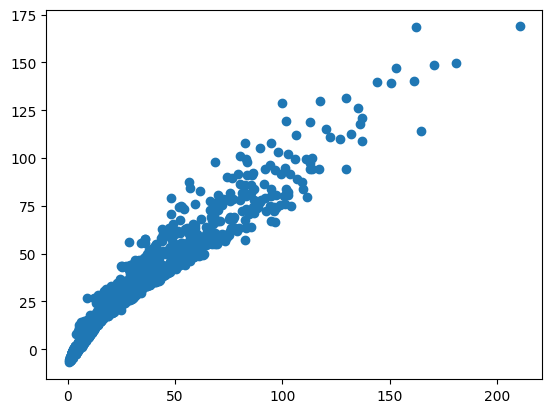

In [ ]:
y_pred_test = linear_model.predict(X)

print("Linear Regression Results")
print("Mean Absolute Error:", mean_absolute_error(y, y_pred_test))
print("Mean Squared Error:", mean_squared_error(y, y_pred_test))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y, y_pred_test)))
print("R2 Score:", r2_score(y, y_pred_test))
plt.scatter(y, y_pred_test)

Decision Tree Regression Results
Mean Absolute Error: 0.4131146432194791
Mean Squared Error: 5.868310517416303
Root Mean Squared Error: 2.4224596007810537
R2 Score: 0.9877885202528502


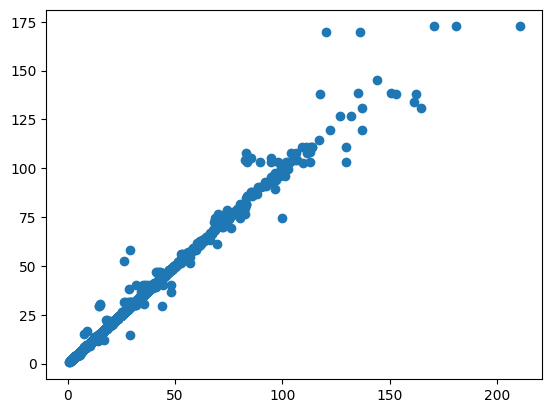

In [ ]:
decision_pred_test = decision_tree_model.predict(X)
print("Decision Tree Regression Results")
print("Mean Absolute Error:", mean_absolute_error(y, decision_pred_test))
print("Mean Squared Error:", mean_squared_error(y, decision_pred_test))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y, decision_pred_test)))
print("R2 Score:", r2_score(y, decision_pred_test))
plt.scatter(y, decision_pred_test)

In [ ]:
xgb_preds_test = xgb_model.predict(X)
print("XGBoost RMSE:", mean_squared_error(y, xgb_preds_test))
print("XGBoost R²:", r2_score(y, xgb_preds_test))


XGBoost RMSE: 3.0598416896404848
XGBoost R²: 0.9936327168251178


In [ ]:
lgb_preds_test = lgb_model.predict(X)
print("LightGBM RMSE:", mean_squared_error(y, lgb_preds_test))
print("LightGBM R²:", r2_score(y, lgb_preds_test))


LightGBM RMSE: 3.902538775705822
LightGBM R²: 0.9918791323191636


In [ ]:
cat_preds_test= cat_model.predict(X)
print("CatBoost RMSE:", mean_squared_error(y, cat_preds_test))
print("CatBoost R²:", r2_score(y, cat_preds_test))

CatBoost RMSE: 1.4898153765509037
CatBoost R²: 0.9968998146495912


In [ ]:
# Save predictions to the test DataFrame
RFMScores_test.loc[X.index, 'CLV_Linear'] = y_pred_test 
RFMScores_test.loc[X.index, 'CLV_DecisionTree'] = decision_pred_test
RFMScores_test.loc[X.index, 'CLV_XGBoost'] = xgb_preds_test
RFMScores_test.loc[X.index, 'CLV_LightGBM'] = lgb_preds_test
RFMScores_test.loc[X.index, 'CLV_CatBoost'] = cat_preds_test
RFMScores_test.to_csv("CLV_Predictions.csv", index=False)